In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

Epoch     0 | Total=3.260e-01 | Phys=1.525e-04 | Data=2.826e-01 | BC=4.329e-02 | a=-0.0990
Epoch   200 | Total=2.261e-02 | Phys=1.637e-04 | Data=2.125e-02 | BC=1.197e-03 | a=-0.2348
Epoch   400 | Total=1.307e-02 | Phys=1.188e-04 | Data=1.193e-02 | BC=1.023e-03 | a=-0.3018
Epoch   600 | Total=9.719e-03 | Phys=1.042e-04 | Data=8.785e-03 | BC=8.304e-04 | a=-0.3470
Epoch   800 | Total=7.986e-03 | Phys=4.824e-05 | Data=7.198e-03 | BC=7.394e-04 | a=-0.3800
Epoch  1000 | Total=7.155e-03 | Phys=5.236e-05 | Data=6.402e-03 | BC=7.003e-04 | a=-0.4055
Epoch  1200 | Total=6.678e-03 | Phys=3.697e-05 | Data=5.923e-03 | BC=7.178e-04 | a=-0.4255
Epoch  1400 | Total=6.424e-03 | Phys=2.981e-05 | Data=5.567e-03 | BC=8.276e-04 | a=-0.4417
Epoch  1600 | Total=7.015e-03 | Phys=2.476e-05 | Data=6.023e-03 | BC=9.672e-04 | a=-0.4552
Epoch  1800 | Total=6.075e-03 | Phys=1.954e-05 | Data=5.357e-03 | BC=6.981e-04 | a=-0.4651
Epoch  2000 | Total=6.049e-03 | Phys=1.616e-05 | Data=5.313e-03 | BC=7.196e-04 | a=-0.4735

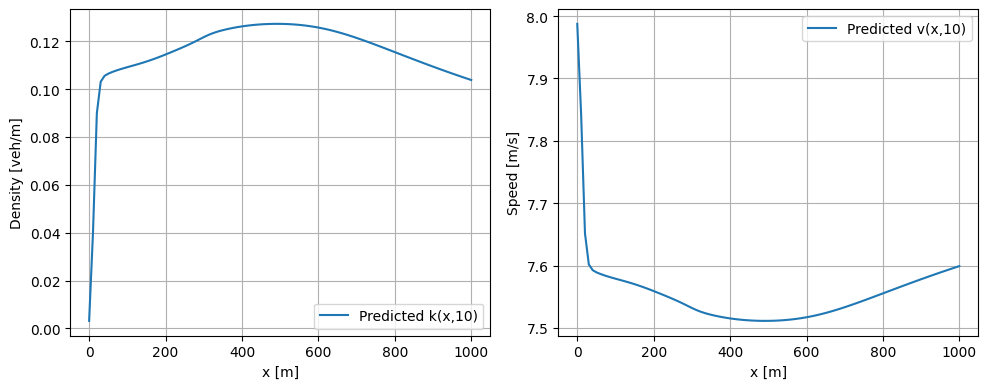

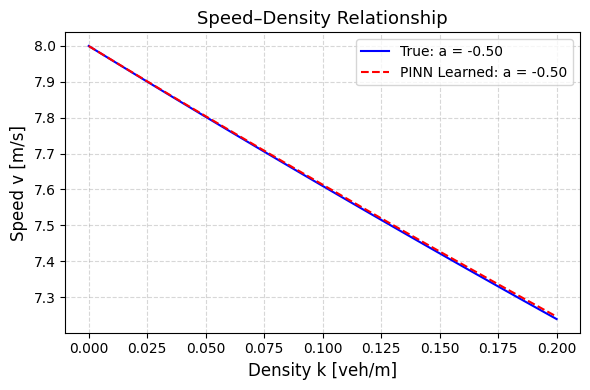

In [3]:
# ==============================
# 1. Physical parameters
# ==============================
v0 = 8.0         # free flow speed [m/s]
a_true = -0.5     # true congestion sensitivity
L = 1000.0         # lane length [m]
T = 20.0          # simulation time [s]

# ==============================
# 2. Generate synthetic training data
# ==============================
def true_k(x, t):
    """True hostler density field for synthetic data"""
    return 0.1 + 0.05 * np.sin(np.pi * x / L) * np.exp(-t / 15)

def true_v(k):
    """True speed field based on LWR relation"""
    return v0 * np.exp(a_true * k)

# sample training data points
Nx_data, Nt_data = 30, 30
x_data = np.linspace(0, L, Nx_data)
t_data = np.linspace(0, T, Nt_data)
X_data, T_data = np.meshgrid(x_data, t_data)
K_data = true_k(X_data, T_data)
V_data = true_v(K_data)

x_d = torch.tensor(X_data.flatten(), dtype=torch.float32).view(-1, 1)
t_d = torch.tensor(T_data.flatten(), dtype=torch.float32).view(-1, 1)
k_d = torch.tensor(K_data.flatten(), dtype=torch.float32).view(-1, 1)
v_d = torch.tensor(V_data.flatten(), dtype=torch.float32).view(-1, 1)

# ==============================
# 3. Define PINN network
# ==============================
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
        # Trainable congestion parameter 'a'
        self.a = nn.Parameter(torch.tensor([-0.1], dtype=torch.float32))

    def forward(self, x, t):
        xt = torch.cat((x, t), dim=1)
        k_pred = self.net(xt)
        v_pred = v0 * torch.exp(self.a * k_pred)
        return k_pred, v_pred

# Instantiate model
model = PINN()

# ==============================
# 4. Define PDE residual
# ==============================
def pde_residual(x, t):
    x.requires_grad_(True)
    t.requires_grad_(True)
    k_pred, v_pred = model(x, t)

    # Compute partial derivatives
    k_t = torch.autograd.grad(k_pred, t, grad_outputs=torch.ones_like(k_pred),
                              retain_graph=True, create_graph=True)[0]
    q = v_pred * k_pred
    q_x = torch.autograd.grad(q, x, grad_outputs=torch.ones_like(q),
                              retain_graph=True, create_graph=True)[0]

    r = k_t + q_x
    return r

# ==============================
# 5. Define losses
# ==============================
w_f, w_d, w_b = 1.0, 1.0, 1.0

def loss_function(x_d, t_d, k_d, v_d):
    # Physics loss (residual)
    x_f = torch.rand_like(x_d) * L
    t_f = torch.rand_like(t_d) * T
    r = pde_residual(x_f, t_f)
    L_phys = torch.mean(r**2)

    # Data loss
    k_pred, v_pred = model(x_d, t_d)
    L_data = torch.mean((k_pred - k_d)**2 + (v_pred - v_d)**2)

    # Boundary & initial conditions
    # v(0, t) = v0  (free flow)
    t_bc = torch.linspace(0, T, 20).view(-1, 1)
    x0 = torch.zeros_like(t_bc)
    _, v_in = model(x0, t_bc)
    L_bc_in = torch.mean((v_in - v0)**2)

    # k(x, 0) = k0(x)
    x_ic = torch.linspace(0, L, 20).view(-1, 1)
    t0 = torch.zeros_like(x_ic)
    k0 = torch.tensor(true_k(x_ic.detach().numpy(), 0.0), dtype=torch.float32)
    k_init, _ = model(x_ic, t0)
    L_bc_init = torch.mean((k_init - k0)**2)

    L_bc = L_bc_in + L_bc_init

    return w_f*L_phys + w_d*L_data + w_b*L_bc, L_phys, L_data, L_bc


# ==============================
# 6. Training with loss tracking
# ==============================
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# For recording losses
loss_history = {'total': [], 'phys': [], 'data': [], 'bc': [], 'a': []}

for epoch in range(5000):
    optimizer.zero_grad()
    L_total, L_phys, L_data, L_bc = loss_function(x_d, t_d, k_d, v_d)
    L_total.backward()
    optimizer.step()

    # Record
    loss_history['total'].append(L_total.item())
    loss_history['phys'].append(L_phys.item())
    loss_history['data'].append(L_data.item())
    loss_history['bc'].append(L_bc.item())
    loss_history['a'].append(model.a.item())

    # Print every 200 epochs
    if epoch % 200 == 0:
        print(f"Epoch {epoch:5d} | "
              f"Total={L_total.item():.3e} | "
              f"Phys={L_phys.item():.3e} | "
              f"Data={L_data.item():.3e} | "
              f"BC={L_bc.item():.3e} | "
              f"a={model.a.item():.4f}")


# ==============================
# 7. Visualization
# ==============================
x_plot = torch.linspace(0, L, 100).view(-1, 1)
t_plot = torch.full_like(x_plot, 10.0)  # t = 10s snapshot
k_pred, v_pred = model(x_plot, t_plot)
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.plot(x_plot.detach(), k_pred.detach(), label='Predicted k(x,10)')
plt.xlabel('x [m]'); plt.ylabel('Density [veh/m]')
plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(x_plot.detach(), v_pred.detach(), label='Predicted v(x,10)')
plt.xlabel('x [m]'); plt.ylabel('Speed [m/s]')
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()

# ==============================
# 8. Plot Speed–Density Function
# ==============================

# Generate density range
k_vals = np.linspace(0, 0.2, 100)  # hostler density range [veh/m]

# True relationship
v_true = v0 * np.exp(a_true * k_vals)

# Learned relationship (using trained a)
a_learned = model.a.item()
v_learned = v0 * np.exp(a_learned * k_vals)

plt.figure(figsize=(6, 4))
plt.plot(k_vals, v_true, 'b-', label=f'True: a = {a_true:.2f}')
plt.plot(k_vals, v_learned, 'r--', label=f'PINN Learned: a = {a_learned:.2f}')
plt.xlabel('Density k [veh/m]', fontsize=12)
plt.ylabel('Speed v [m/s]', fontsize=12)
plt.title('Speed–Density Relationship', fontsize=13)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

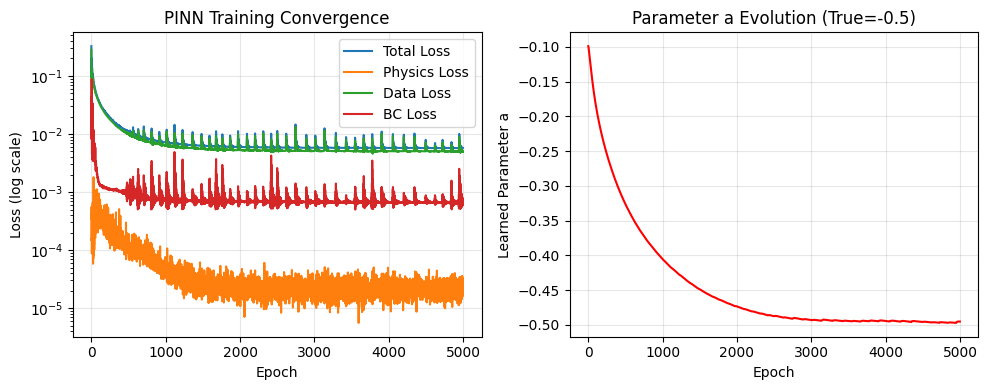

In [4]:
# ==============================
# 9. Plot training convergence
# ==============================
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.semilogy(loss_history['total'], label='Total Loss')
plt.semilogy(loss_history['phys'], label='Physics Loss')
plt.semilogy(loss_history['data'], label='Data Loss')
plt.semilogy(loss_history['bc'], label='BC Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.title('PINN Training Convergence')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
plt.plot(loss_history['a'], 'r-')
plt.xlabel('Epoch')
plt.ylabel('Learned Parameter a')
plt.title(f'Parameter a Evolution (True={a_true})')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
